In [10]:
# LinearRegression is a machine learning library for linear regression
from sklearn.linear_model import LinearRegression

# pandas and numpy are used for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn are used for plotting graphs
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# yfinance is used to fetch data
import yfinance as yf

import warnings
warnings.simplefilter("ignore")

[*********************100%***********************]  1 of 1 completed


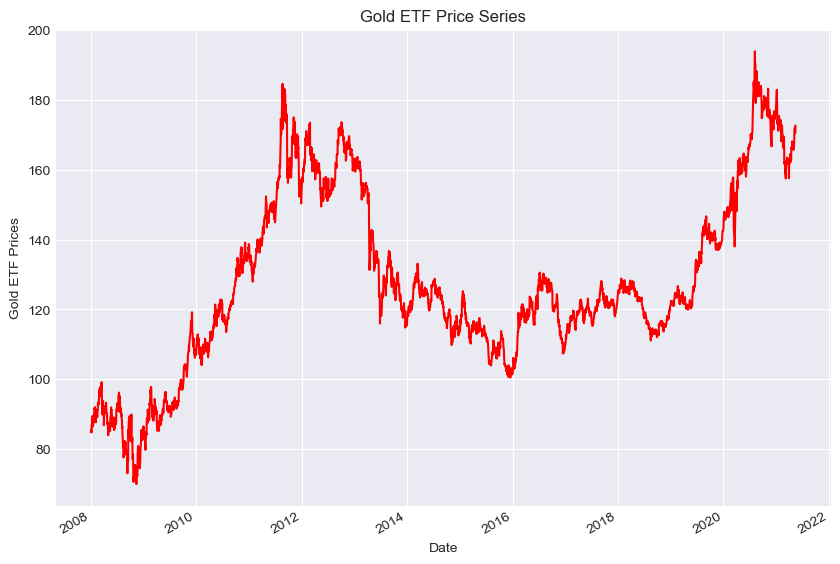

In [11]:
# Read data
Df = yf.download('GLD', '2008-01-01', '2021-5-17', auto_adjust=True)

# Only keep close columns
Df = Df[['Close']]

# Drop rows with missing values
Df = Df.dropna()

# Plot the closing price of GLD
Df.Close.plot(figsize=(10, 7),color='r')
plt.ylabel("Gold ETF Prices")
plt.title("Gold ETF Price Series")
plt.show()

In [13]:
# Define explanatory variables
Df['S_3'] = Df['Close'].rolling(window=3).mean()
Df['S_9'] = Df['Close'].rolling(window=9).mean()
Df['next_day_price'] = Df['Close'].shift(-1)

Df = Df.dropna()
X = Df[['S_3', 'S_9']]

# Define dependent variable
y = Df['next_day_price']

In [14]:
# Split the data into train and test dataset
t = .8
t = int(t*len(Df))

# Train dataset
X_train = X[:t]
y_train = y[:t]

# Test dataset
X_test = X[t:]
y_test = y[t:]

# Create a linear regression model
linear = LinearRegression().fit(X_train, y_train)
print("Linear Regression model")
print("Gold ETF Price (y) = %.2f * 3 Days Moving Average (x1) \
+ %.2f * 9 Days Moving Average (x2) \
+ %.2f (constant)" % (linear.coef_[0], linear.coef_[1], linear.intercept_))

Linear Regression model
Gold ETF Price (y) = 1.20 * 3 Days Moving Average (x1) + -0.21 * 9 Days Moving Average (x2) + 0.43 (constant)


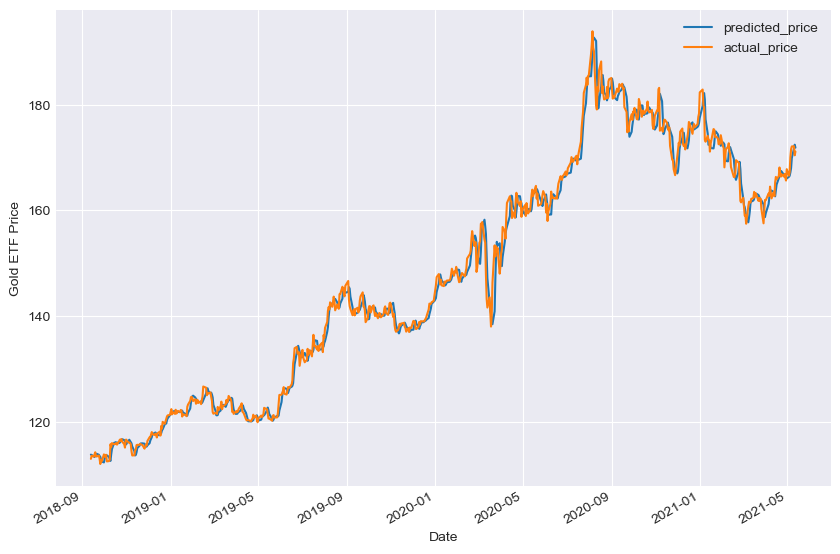

99.21

In [15]:
# Predicting the Gold ETF prices
predicted_price = linear.predict(X_test)
predicted_price = pd.DataFrame(
    predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(10, 7))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold ETF Price")
plt.show()

# R square
r2_score = linear.score(X[t:], y[t:])*100
float("{0:.2f}".format(r2_score))

In [16]:
gold = pd.DataFrame()

gold['price'] = Df[t:]['Close']
gold['predicted_price_next_day'] = predicted_price
gold['actual_price_next_day'] = y_test
gold['gold_returns'] = gold['price'].pct_change().shift(-1)

In [17]:
gold['signal'] = np.where(gold.predicted_price_next_day.shift(1) < gold.predicted_price_next_day,1,0)
gold.head()

,price,predicted_price_next_day,actual_price_next_day,gold_returns,signal
Date,,,,,
2018-09-13,113.760002,113.819265,113.019997,-0.006505,0
2018-09-14,113.019997,113.750286,113.610001,0.005220,0
2018-09-17,113.610001,113.509832,113.440002,-0.001496,0
2018-09-18,113.440002,113.378622,113.879997,0.003879,0
2018-09-19,113.879997,113.715972,114.269997,0.003425,1


In [18]:
gold['actual_price_next_day'] = gold.price.shift(-1)
gold['actual_signal'] = np.where(gold.actual_price_next_day.shift(1) < gold.actual_price_next_day,1,0)
gold.tail()

,price,predicted_price_next_day,actual_price_next_day,gold_returns,signal,actual_signal
Date,,,,,,
2021-05-06,170.059998,168.012001,171.589996,0.008997,1,1
2021-05-07,171.589996,169.913394,172.110001,0.003031,1,1
2021-05-10,172.110001,171.724876,172.139999,0.000174,1,1
2021-05-11,172.139999,172.439152,170.429993,-0.009934,1,0
2021-05-12,170.429993,171.876467,NaN,NaN,0,0


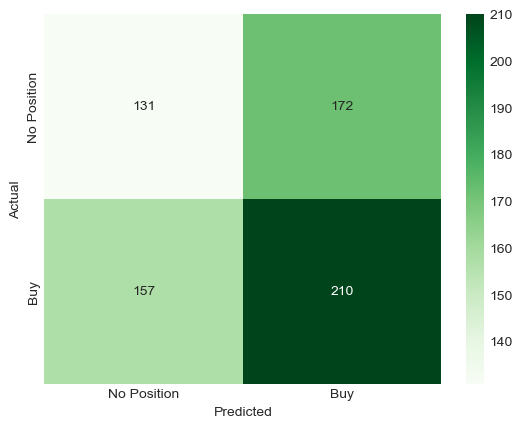

In [19]:
from sklearn.metrics import confusion_matrix
array = confusion_matrix(gold['actual_signal'], gold['signal'])
df = pd.DataFrame(array, index = ['No Position','Buy'], columns = ['No Position','Buy'])

# Plot the heatmap
import seaborn as sns
sns.heatmap(df, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [20]:
from sklearn.metrics import classification_report
print(classification_report(gold['actual_signal'], gold['signal'], target_names=['No Position','Buy']))

              precision    recall  f1-score   support

 No Position       0.45      0.43      0.44       303
         Buy       0.55      0.57      0.56       367

    accuracy                           0.51       670
   macro avg       0.50      0.50      0.50       670
weighted avg       0.51      0.51      0.51       670



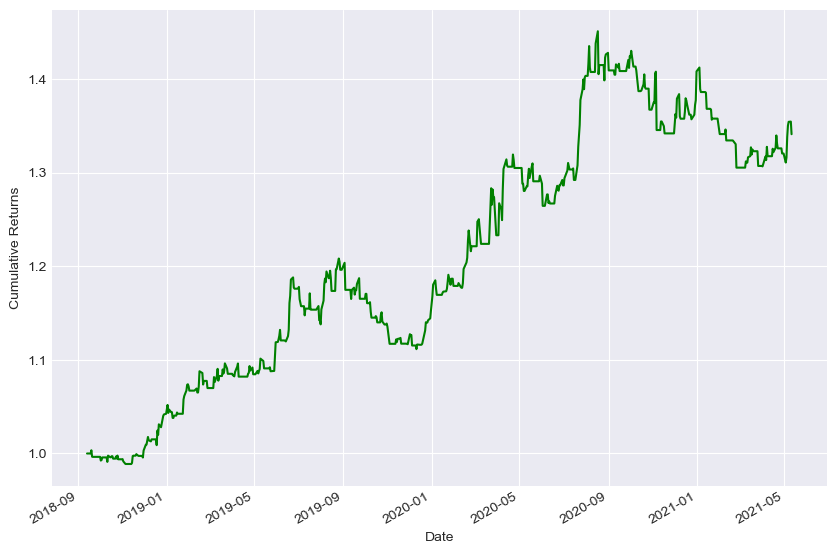

In [21]:
gold['strategy_returns'] = gold.signal * gold['gold_returns']
((gold['strategy_returns']+1).cumprod()).plot(figsize=(10,7),color='g')
plt.ylabel('Cumulative Returns')
plt.show()

In [22]:
'Sharpe Ratio %.2f' % (gold['strategy_returns'].mean()/gold['strategy_returns'].std()*(252**0.5))

'Sharpe Ratio 1.08'

In [25]:
import datetime as dt
current_date = dt.datetime.now()
data = yf.download('GLD', '2008-06-01', current_date, auto_adjust=True)
data['S_3'] = data['Close'].rolling(window=3).mean()
data['S_9'] = data['Close'].rolling(window=9).mean()
data = data.dropna()
data['predicted_gold_price'] = linear.predict(data[['S_3', 'S_9']])
data['signal'] = np.where(data.predicted_gold_price.shift(1) < data.predicted_gold_price,"Buy","No Position")
data.tail(1)[['signal','predicted_gold_price']].T

[*********************100%***********************]  1 of 1 completed


Date,2023-03-10
signal,Buy
predicted_gold_price,170.748367
